## One Shot Learning on Omniglot

Using a small ConvNet to meta-learn the heck out of Omniglot characters. Nice to see malayalam in my dataset. The model and dataloader are present in siamese.py and omniglot_loader.py respectively.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms
import os
import cv2
import matplotlib.pyplot as plt

from siamese import SiameseNet, train_step, test_step, oneshot_test
from omniglot_loader import OmniLoader

Gettin image list....
964 classes present
Gettin image list....
964 classes present
torch.Size([16, 1, 64, 64])
tensor([0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0.])


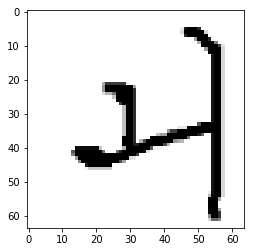

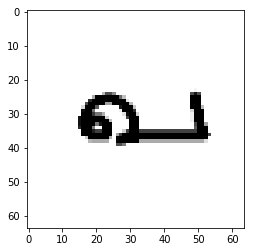

In [2]:
data = OmniLoader("./images_background")
trainloader = torch.utils.data.DataLoader(data, batch_size=16, num_workers=0, shuffle = True)

data_val = OmniLoader("./images_background", validation = True)
validationloader = torch.utils.data.DataLoader(data_val, batch_size=16, num_workers=0, shuffle = True)

data_loader = iter(trainloader)
data, data2, label = next(data_loader)

print(data.shape)
print(label.view(-1))
plt.imshow(data[0][0], cmap = "gray")
plt.show()
plt.imshow(data2[0][0], cmap = "gray")
plt.show()


In [6]:
netS = SiameseNet(image_size = (64, 64))
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(netS.parameters(), lr = 0.001, weight_decay = 1e-5)

### Training Loop

In [7]:
epochs = 5

iterations, train_losses, validation_losses = [], [], []

for e in range(epochs):
    print("Epoch", e+1)
    for i, data in enumerate(trainloader):
        x, y, sim = data
        
        train_loss = train_step(netS, optimizer, loss_fn, x, y, sim)
        
        
        if i%50 == 0:
          print("[", e+1, "/", epochs, "][", i, "/",len(trainloader),"]", "Training Loss :", train_loss)
        
        if i%10 == 0:
          iterations.append(e*len(trainloader) + i)
          train_losses.append(train_loss)
            
        
    for i, data in enumerate(validationloader):
        
        val_loss = test_step(netS, loss_fn, x, y, sim)
        validation_losses.append(val_loss)
        

    print("Validation Loss:", sum(validation_losses)/len(validation_losses))   
    support_set, query_set, class_labels = data_val.get_oneshot_task(ways = 10)
    oneshot_test(netS, support_set, query_set, class_labels)


Epoch 1
[ 1 / 5 ][ 0 / 964 ] Training Loss : 0.6767430901527405
[ 1 / 5 ][ 50 / 964 ] Training Loss : 0.6147996187210083
[ 1 / 5 ][ 100 / 964 ] Training Loss : 0.6711707711219788
[ 1 / 5 ][ 150 / 964 ] Training Loss : 0.5206223726272583
[ 1 / 5 ][ 200 / 964 ] Training Loss : 0.5891808867454529
[ 1 / 5 ][ 250 / 964 ] Training Loss : 0.928870439529419
[ 1 / 5 ][ 300 / 964 ] Training Loss : 0.45701512694358826
[ 1 / 5 ][ 350 / 964 ] Training Loss : 0.6850791573524475
[ 1 / 5 ][ 400 / 964 ] Training Loss : 0.4811376631259918
[ 1 / 5 ][ 450 / 964 ] Training Loss : 0.34864699840545654
[ 1 / 5 ][ 500 / 964 ] Training Loss : 0.4924875497817993
[ 1 / 5 ][ 550 / 964 ] Training Loss : 0.3746771812438965
[ 1 / 5 ][ 600 / 964 ] Training Loss : 0.5522628426551819
[ 1 / 5 ][ 650 / 964 ] Training Loss : 0.3073861002922058
[ 1 / 5 ][ 700 / 964 ] Training Loss : 0.4146578907966614
[ 1 / 5 ][ 750 / 964 ] Training Loss : 0.3961125910282135
[ 1 / 5 ][ 800 / 964 ] Training Loss : 0.5030719637870789
[ 1 / 5 

### One Shot Test

We use the images from the evaluation set to test the network. It consists of alphabets and characters that the network hasn't been trained on. This is between alphabet testing. It draws one image from 'm' classes (m-way one shot learning) to form the support test, and tests all the other images from those same classes, the query set, against the support set.

Gettin image list....
659 classes present
torch.Size([10, 1, 64, 64]) torch.Size([190, 1, 64, 64])


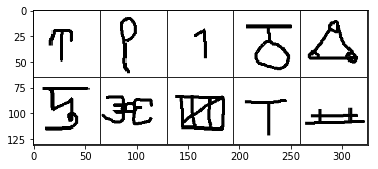

0 / 190
50 / 190
100 / 190
150 / 190
One shot accuracy:  0.8526315789473684 



In [10]:
data = OmniLoader("./images_evaluation")

support_set, query_set, class_labels = data.get_oneshot_task(ways = 10)
print(support_set.shape, query_set.shape)

grid = torchvision.utils.make_grid(support_set, nrow = 5, padding = 1, pad_value = 0.15)
grid = np.transpose(grid, (1, 2, 0))
plt.imshow(grid)
plt.show()

oneshot_test(netS, support_set, query_set, class_labels)